In [110]:
#importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [111]:
#load the date to a pandas dataframe
df=pd.read_csv("data/Bitstamp_BTCUSD_d.csv")
df.head()

,Unix,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD;;;;;;;;
0,1660003200,2022-08-09 00:00:00,BTC/USD,23811.29,23836.69,23740.05,23785.56,5.982832,142305.019020144;;;;;;;;
1,1659916800,2022-08-08 00:00:00,BTC/USD,23177.72,24246.06,23169.64,23821.68,1845.040918,43951974.328593954;;;;;;;;
2,1659830400,2022-08-07 00:00:00,BTC/USD,22946.00,23411.55,22855.14,23187.62,691.383374,16031534.945992354;;;;;;;;
3,1659744000,2022-08-06 00:00:00,BTC/USD,23326.50,23354.54,22919.76,22956.61,672.145297,15430177.444037944;;;;;;;;
4,1659657600,2022-08-05 00:00:00,BTC/USD,22630.14,23478.00,22587.94,23326.40,2070.359898,48294043.12494047;;;;;;;;


Text(0, 0.5, 'Preço')

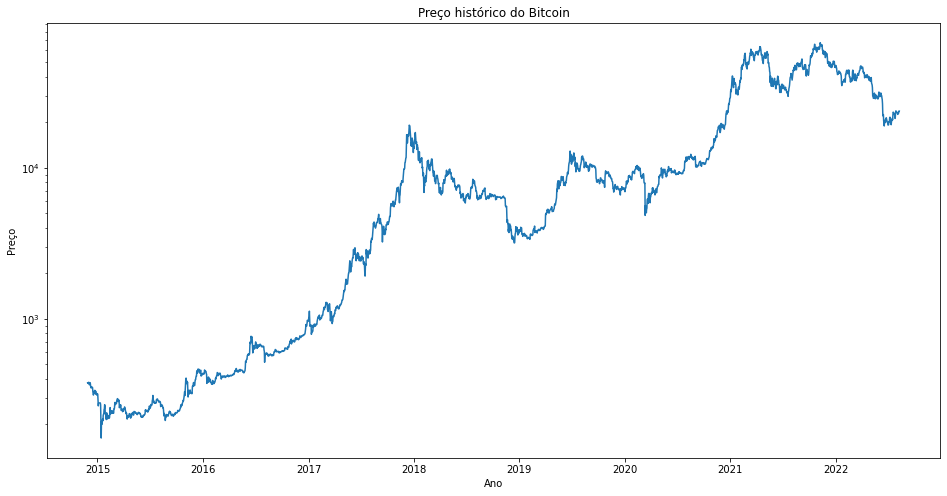

In [112]:
#format date column
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
#set date column as index
df.index=df['Date']
#plot figure
plt.figure(figsize=(16,8))
plt.plot(df["Close"])
plt.yscale("log")
plt.title("Preço histórico do Bitcoin")
plt.xlabel("Ano")
plt.ylabel("Preço")


In [113]:
#sort df ascending date
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

new_dataset

,Date,Close
0,2014-11-28 00:00:00,376.28
1,2014-11-29 00:00:00,376.72
2,2014-11-30 00:00:00,373.34
3,2014-12-01 00:00:00,378.39
4,2014-12-02 00:00:00,379.25
...,...,...
2807,2022-08-05 00:00:00,23326.4
2808,2022-08-06 00:00:00,22956.61
2809,2022-08-07 00:00:00,23187.62
2810,2022-08-08 00:00:00,23821.68


In [114]:
#get the close values as a vertical array ( add one more dimension to the array)
dataframe_close = new_dataset.Close.values
close_values=dataframe_close.reshape(-1,1)


In [115]:
#split the values in train and test
dataset_train = np.array(close_values[:int(close_values.shape[0]*0.8)])
dataset_test = np.array(close_values[int(close_values.shape[0]*0.8):])


In [116]:
#normalize the data 
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.fit_transform(dataset_test)
dataset_test.shape




(563, 1)

In [117]:
#create dataset with the last (timesteps) prices (x) as with the next movement (y, 1 if price up and 0 if price down)
timesteps = 10
 
def create_dataset2(df):
    x = []
    y = []
    for i in range(timesteps, df.shape[0]):
        x.append(df[i-timesteps:i, 0])
        if(df[i,0]>df[i-1,0]):
            y.append(1)
        else:
            y.append(0)
    x = np.array(x)
    y = np.array(y)
    return x,y

In [118]:
x_train, y_train = create_dataset2(dataset_train)
x_test, y_test = create_dataset2(dataset_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_test.shape


(553, 2)

In [119]:
#create a 3D array to use in LTSM layer
#Tensors are the data structure used by machine learning systems, and getting to know them is an essential skill you should build early on.
#LTSM receive 3D tensor

#A tensor is a container for numerical data. It is the way we store the information that we’ll use within our system. [samples, time steps, features]
#The batch size is the size of the training batch you use. It can be anything and doesn't effect the size of the LSTM layer. It just modifies the gradient update step.

#Time steps is the one that determines the size, because it's the number of times that you unroll your LSTM cell. So, that is right, total number of unrolled cells is equal to 5.

#The features is related to the series you want to input/predict. If it is 1, the series is univariate, otherwise it is multi-variate and doesn't have anything to do with the number of cells unrolled.


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [120]:
#variables for test
units = 96
dropout = 0.5
outputs = y_test.shape[1]
features = x_train.shape[2]
#create the sequence model
model = Sequential()
#we initialized our model as a sequential one with 96 units in the output’s dimensionality. We used return_sequences=True to make the LSTM layer with three-dimensional input and input_shape to shape our dataset.
#inputs: A 3D tensor with shape [batch, timesteps, feature]
# units : dimensionality of the output space .I think that more units (greater dimension of hidden states) will help the network to remember more complex patterns.The main point is that there is usually no rule for the number of hidden nodes you should use, 
# it is something you have to figure out for each case by trial and error.
#return sequences : Whether to return the last output. in the output sequence, or the full sequence. Default: False .This allows us to have 3D output from hidden LSTM layer as input to the next.
#stateful:  If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
#input_shape = [n_steps,n_features]
model.add(LSTM(units=units, input_shape=(timesteps, features)))
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
#  Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged. Making the dropout fraction 0.2 drops 20% of the layers
# reduce overfitting and improve generalization error in deep neural networks of all kinds.
#One approach to reduce overfitting is to fit all possible different neural networks on the same dataset and to average the predictions from each model. 
# This is not feasible in practice, and can be approximated using a small collection of different models, called an ensemble
# During training, some number of layer outputs are randomly ignored or “dropped out.” 
# This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. 
# In effect, each update to a layer during training is performed with a different “view” of the configured layer.
model.add(Dropout(dropout,))
#Finally, we added a dense layer with a value of 1 because we want to output one value.
#The dense layer’s neuron in a model receives output from every neuron of its preceding layer, where neurons of the dense layer perform matrix-vector multiplication.
#dense layer is basically used for changing the dimensions of the vector.
model.add(Dense(units=units, activation='relu'))
model.add(Dense(units=outputs))
model.summary()
#num_params = g × [h(h+i) + h]
#g, no. of FFNNs in a unit (RNN has 1, GRU has 3, LSTM has 4)
#h, size of hidden units (units)
#i, dimension/size of input 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 96)                37632     
                                                                 
 dropout_5 (Dropout)         (None, 96)                0         
                                                                 
 dense_10 (Dense)            (None, 96)                9312      
                                                                 
 dense_11 (Dense)            (None, 2)                 194       
                                                                 
Total params: 47,138
Trainable params: 47,138
Non-trainable params: 0
_________________________________________________________________


In [129]:
#We used loss='mean_squared_error' because it is a regression problem, and the adam optimizer to update network weights iteratively based on training data.
#The purpose of loss functions is to compute the quantity that a model should seek to minimize during training.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [130]:
#epochs: Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
#batch_size: Number of samples per gradient update.
model.fit(x_train, y_train, epochs=15, batch_size=64)
#model.save('stock_prediction.h5')

Epoch 1/15
35/35 [==============================] - 3s 9ms/step - loss: 0.6967 - accuracy: 0.5364
Epoch 2/15
35/35 [==============================] - 0s 8ms/step - loss: 0.6955 - accuracy: 0.5319
Epoch 3/15
35/35 [==============================] - 0s 8ms/step - loss: 0.6926 - accuracy: 0.5413
Epoch 4/15
35/35 [==============================] - 0s 8ms/step - loss: 0.6947 - accuracy: 0.5386
Epoch 5/15
35/35 [==============================] - 0s 8ms/step - loss: 0.6918 - accuracy: 0.5400
Epoch 6/15
35/35 [==============================] - 0s 8ms/step - loss: 0.6921 - accuracy: 0.5355
Epoch 7/15
35/35 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.5342
Epoch 8/15
35/35 [==============================] - 0s 8ms/step - loss: 0.6919 - accuracy: 0.5382
Epoch 9/15
35/35 [==============================] - 0s 8ms/step - loss: 0.6911 - accuracy: 0.5377
Epoch 10/15
35/35 [==============================] - 0s 7ms/step - loss: 0.6897 - accuracy: 0.5409
Epoch 11/15
35/35 [

In [134]:
#model.get_config()["layers"][1]["config"]
loss,accuracy = model.evaluate(x_test, y_test, batch_size=32)

accuracy

18/18 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.5009


0.5009041428565979

In [132]:
predictions = model.predict(x_test)


In [133]:
count = 0
for index in range(len(predictions)):
    if y_test[index][0] == 1:
        if predictions[index][0] > predictions[index][1]:
            count+=1
    else:
        if predictions[index][1] > predictions[index][0]:
            count+=1
print(count, count/len(predictions))

277 0.5009041591320073


In [127]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#calculation of the error metrics in predictions
mae = mae(y_test_scaled,predictions)
mape = mape(y_test_scaled,predictions)
mse = mse(y_test_scaled,predictions)
print(mae,mape,mse)

NameError: name 'y_test_scaled' is not defined